In [1]:
import numpy as np
import pandas as pd
import emat
emat.versions()

emat 0.6.4, plotly 5.24.1


# Experimental Designs

A fundamental part of TMIP-EMAT is the development of a "design of experiments"
to use in conjunction with a model. The experimental design lays out a list of 
model experiments to be conducted, and can be constructed in a number of different 
ways: it can be a systematic design, a random design, or something in between.

Developing an experimental design using TMIP-EMAT requires that an exploratory
scope is defined, to identify the model inputs and their potential values.  To 
illustrate designs, we'll work with the scope from the road test model.

In [2]:
import emat.examples
scope, db, model = emat.examples.road_test()

## Univariate Sensitivity Tests

One of the simplest experimental designs, and one used often in practice for 
transportation models, is a series of univariate sensitivity tests.  In this 
design, a set of baseline or default model inputs is used as a starting point,
and then input parameters are changed one at a time to non-default values.
Univariate sensitivity tests are excellent tools for debugging and quality checking
the model code, as they allow modelers to confirm that each modeled input is 
(or is intentionally not) triggering some change in the model outputs.

TMIP-EMAT provides the `design_sensitivity_tests` function to automatically 
generate a design of univariate sensitivity tests, given an exploratory scope.
This tool will systematically generate experiments where all of the inputs but one are
set to their default values, and the holdout input is then set to alternative values.
For numerical inputs, the alternative values are the minimum or maximum
value (one experiment for each, if they are different from the default). For categorical
and boolean inputs, one experiment is created for each possible input value.

In [3]:
from emat.experiment.experimental_design import design_sensitivity_tests
ust = design_sensitivity_tests(scope, design_name='univariate_tests')
ust

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
0,60,100,0.15,4.0,100,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
1,60,100,0.10,4.0,100,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
2,60,100,0.20,4.0,100,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
3,60,100,0.15,3.5,100,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
4,60,100,0.15,5.5,100,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
5,60,100,0.15,4.0,80,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
6,60,100,0.15,4.0,150,0.075,100,0.030,0.0100,10.0,30,GO Bond,False
7,60,100,0.15,4.0,100,0.001,100,0.030,0.0100,10.0,30,GO Bond,False
8,60,100,0.15,4.0,100,0.250,100,0.030,0.0100,10.0,30,GO Bond,False
9,60,100,0.15,4.0,100,0.075,95,0.030,0.0100,10.0,30,GO Bond,False


The output of this function is an `emat.ExperimentalDesign`, which is a subclass of 
a typical pandas DataFrame.  The `emat.ExperimentalDesign` subclass attaches some useful metadata to the 
actual contents of the design, namely: 

- `sampler_name`, which for univariate sensitivity test is `'uni'`, 
- `design_name`, a descriptive name for storing and retrieving experiments and results in a database, and
- `scope`, which contains a reference to the scope used to define this design.

In [4]:
ust.scope is scope

True

In [5]:
ust.sampler_name

'uni'

In [6]:
ust.design_name

'univariate_tests'

## Efficient Designs

The univariate tests, while useful for model debugging and testing, are not the best choice for exploratory modeling, where we want to consider changing many input factors at once. To support multivariate exploratation, TMIP-EMAT includes a design_experiments function that offers several different multivariate samplers.

In [7]:
from emat.experiment.experimental_design import design_experiments

The default multivariate sampler is a basic Latin Hypercube sampler. Meta-models for deterministic simulation experiments, such as a TDM, are best supported by a “space filling” design of experiments, such as Latin Hypercube draws (Sacks, Welch, Mitchell, & Wynn, 1989). 

A Latin Hypercube sample for one dimension is constructed by subdividing the distribution of each input factor into N equally probable ranges, and drawing one random sample within each range. For example, if an input factor is assumed to be uniformly distributed between 0.1 and 0.2, that distribution can be divided into four regions (0.1-0.125, 0.125-0.15, 0.15-0.175, and 0.175-0.2), and one random draw can be made in each region. In the example below, we illustrate exactly this, for the "alpha" parameter in the demo scope.

/home/runner/work/tmip-emat/tmip-emat/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



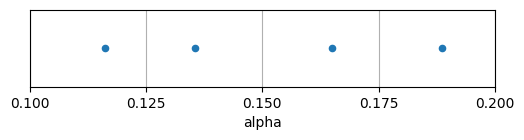

In [8]:
n=4
design = design_experiments(scope, n_samples=n, random_seed=0)
ax = design.plot.scatter(x='alpha', y='initial_capacity', grid=True, figsize=(6,1))
xlim = design.scope['alpha'].range
ax.set_xlim(xlim)
ax.set_xticks(np.linspace(*xlim, n+1))
ax.set_ylabel('')
ax.set_yticks([]);

This ensures better coverage of the entire input range than making four random draws from the full space, which could easily result in a cluster of observations in one part of the space and large void elsewhere. 

Generating a multi-dimensional Latin Hypercube sample for use with multiple input variables follows this same basic technique, although the various draws in each dimension are randomly reordered before being joined with draws in other dimensions, to avoid unintended correlation. Various techniques exist to conduct this random reordering, although there is no agreement in the literature about the “best” orthogonal Latin hypercube design. In most instances, a simple random reordering is sufficient to get pretty good coverage of the space; this is the default in TMIP-EMAT. If a greater degree of orthogonality is desired, one simple method to achieve it is to generate numerous possible sets of random draws, and greedily select the set that minimizes the maximum correlation.

In the figure below, we can see the result across two dimensions for the design of four draws we made previously.  Each dimension is divided in 4, so that each grid row and each grid column has exactly one experiment. 

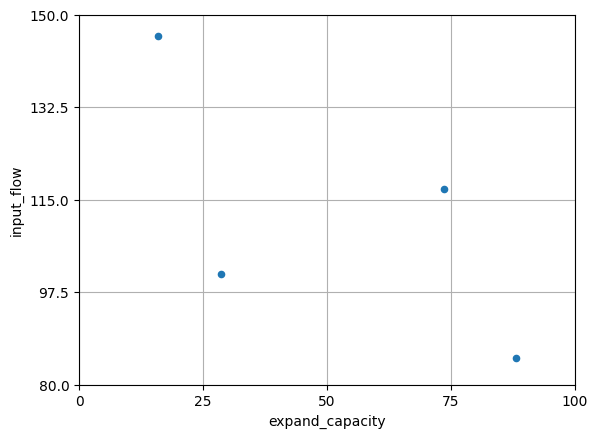

In [9]:
ax = design.plot.scatter(x='expand_capacity', y='input_flow', grid=True)
xlim = design.scope['expand_capacity'].range
ylim = design.scope['input_flow'].range
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(np.linspace(*xlim, n+1))
ax.set_yticks(np.linspace(*ylim, n+1));

The Latin Hypercube design of experiments is advantageous over a factorial or grid-based design, as every experimental observation can provide useful information, even when some input factors are potentially unimportant or spurious. 

As an example, consider the illustration below: 16 experiments are designed, either by making an evenly spaced grid over a two dimensional design space (i.e. a "full factorial" design) or by making the same number of latin hypercube draws.

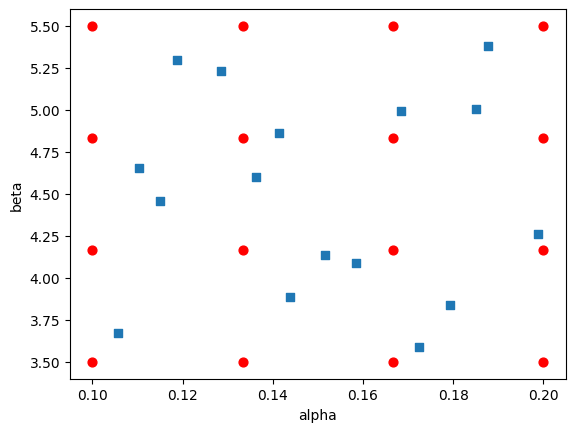

In [10]:
import itertools
factorial = pd.DataFrame(
    itertools.product(np.linspace(*design.scope['alpha'].range, 4),
                      np.linspace(*design.scope['beta'].range, 4)), 
    columns=['alpha', 'beta']
)
lhs = design_experiments(scope, n_samples=16, random_seed=4)

ax = factorial.plot.scatter('alpha', 'beta', color='r', s=40)
lhs.plot.scatter('alpha', 'beta', marker='s', s=40, ax=ax);

If it turns out that the "beta" input is not particularly important for some model outputs,
the information we are actually getting on those outputs will have been derived from inputs that
look like this:

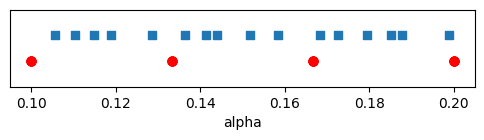

In [11]:
factorial['beta'] = 0
lhs['beta'] = 1
ax = factorial.plot.scatter('alpha', 'beta', color='r', s=40, figsize=(6,1))
lhs.plot.scatter('alpha', 'beta', marker='s', s=40, ax=ax)
ax.set_ylim(-1,2)
ax.set_ylabel('')
ax.set_yticks([]);

Essentially only four unique experiments remain under the full factorial design,
while the Latin hypercube design still offers useful variance over all 16 experiments.

As for the sensitivity tests, the return type for the `design_experiments` function is `emat.ExperimentalDesign`.
The result can be manipulated, saved, or reloaded as any other pandas DataFrame, which allows the the modeler to
review an experimental design before actually running experiments.

In [12]:
lhs

,alpha,amortization_period,beta,debt_type,expand_capacity,input_flow,interest_rate,interest_rate_lock,unit_cost_expansion,value_of_time,yield_curve,free_flow_time,initial_capacity
0,0.179365,24,1,GO Bond,80.162643,120,0.034792,False,140.962953,0.049228,0.007397,60,100
1,0.105645,33,1,GO Bond,64.671571,126,0.030968,False,107.579380,0.137505,0.013873,60,100
2,0.141456,40,1,GO Bond,87.868001,131,0.033288,True,104.801110,0.065576,0.012420,60,100
3,0.118782,26,1,Rev Bond,16.323886,104,0.037495,False,134.207518,0.097838,0.004853,60,100
4,0.128577,29,1,GO Bond,94.525091,146,0.038427,True,117.693257,0.107705,0.016380,60,100
5,0.158509,42,1,Paygo,54.747060,115,0.034314,True,142.451442,0.027920,0.010428,60,100
6,0.172526,36,1,Rev Bond,11.215146,139,0.037112,True,110.962472,0.063330,0.001749,60,100
7,0.114949,32,1,Paygo,83.803917,148,0.036221,False,126.533101,0.083207,0.015196,60,100
8,0.198825,47,1,Paygo,37.148734,88,0.030445,True,115.398483,0.092398,-0.001874,60,100
9,0.185078,19,1,Rev Bond,1.086124,108,0.025081,True,95.638473,0.044881,0.000090,60,100


In addition to the default Latin Hypercube sampler, TMIP-EMAT also includes several other samplers,
which can be invoked through the `sampler` argument of the `design_experiments` function:

- `'ulhs'` is a "uniform" latin hypercube sampler, which ignores all defined distribution shapes and
  correlations from the scope, instead using independent uniform distributions for all inputs. This 
  sampler is useful when designing experiments to support a meta-model for a risk analysis that 
  includes well characterized non-uniform uncertainties and correlations.
- `'mc'` is a simple Monte Carlo sampler, which does not make attempts to ensure good coverage of the 
  sampling space. This sampler minimizes overhead and is useful when running a very large number of
  simulations
  


## Reference Designs

An additional convenience tool is included in TMIP-EMAT to create a "reference" design, which contains only a single experiment that has every input set at the default value.  Although this one experiment is also included in the univariate sensitivity test design, an analyst may not need or want to run that full design. Having the reference case available can be helpful to add context to some exploratory visualizations.  

In [13]:
from emat.experiment.experimental_design import design_refpoint_test
design_refpoint_test(scope)

,free_flow_time,initial_capacity,alpha,beta,input_flow,value_of_time,unit_cost_expansion,interest_rate,yield_curve,expand_capacity,amortization_period,debt_type,interest_rate_lock
0,60,100,0.15,4.0,100,0.075,100,0.03,0.01,10.0,30,GO Bond,False
